# Making Own Mock Data
The last bit of mock data that was tried (in `work-with-true.ipynb`) already contained selection effects that distorted the $35M_\odot$ bump that the code was trying to pin down. To see if the algorithm can even handle it at all and to see what the selection effects do to the analysis, mock data data without selection effects need to be generated and tested, which is what we're doing here

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import arviz as az
from astropy.cosmology import Planck18
from tqdm import tqdm
import seaborn as sns
from MCMC_functions import *

sns.set_context('notebook')
sns.set_palette('colorblind')

%matplotlib inline

## Generating data points

In [2]:
# Parameters:

N = int(1E4) # Number of data points

### Mass function: all mass in units of M_sun
m_scale = -2.35 # exponent in exponential function
m_min = 5 # minimum mass
m_max = 100 # maximum mass
m_bump = 35 # location of bump
sigma_bump = 5 # width of bump

frac_bump = 0.3 # fraction of BH in bump

zmax = 5
dl_max = Planck18.luminosity_distance(zmax)

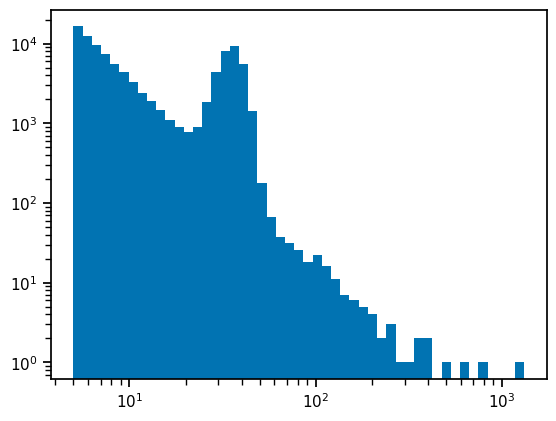

In [3]:
### Plotting Mass Function just to make sure it works properly

samples = generate_masses(int(1E5))

plt.hist(samples, bins=np.logspace(np.log10(5), np.log10(max(samples)), 50))
plt.yscale('log')
plt.xscale('log')

(array([  16.,   83.,  207.,  388.,  641.,  929., 1241., 1756., 2101.,
        2638.]),
 array([  711.31287003,  5407.9502494 , 10104.58762877, 14801.22500814,
        19497.86238751, 24194.49976688, 28891.13714625, 33587.77452561,
        38284.41190498, 42981.04928435, 47677.68666372]),
 <BarContainer object of 10 artists>)

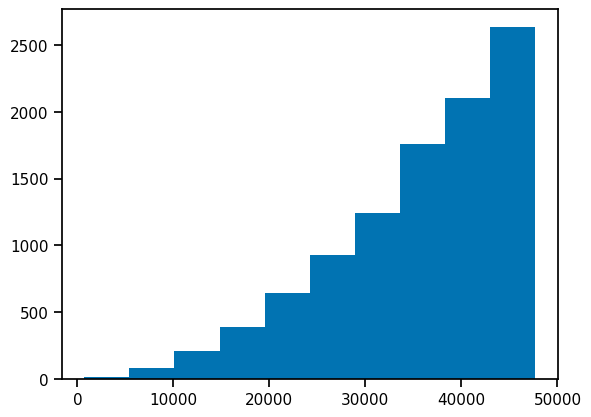

In [4]:
plt.hist(generate_dLs())

In [5]:
dLs = generate_dLs(100)

zs = dLs_to_zs(dLs)
# print(zs)

<AxesSubplot:ylabel='Density'>

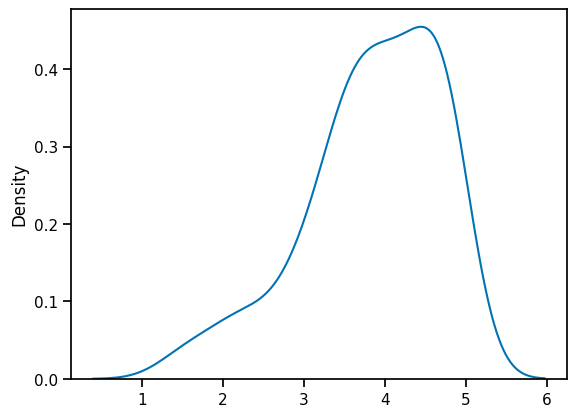

In [6]:
# plt.scatter(zs, dLs)
sns.kdeplot(zs)

## Analyzing synthesized population
Now that the functions are all in place for generating the data, lets synthesize a population to work with and see if the MCMC can reconstruct it. Before we try any sort of way to remove the exponential part and just work with the gaussian by setting `f=1` in the mass generator

First step: generate the data we'll use:

In [16]:
ms = generate_masses(f=1)
d_Ls = generate_dLs()
zs = dLs_to_zs(d_Ls)

35.06243569319512 3.899932028568747 171.71896786596096
(10000,)


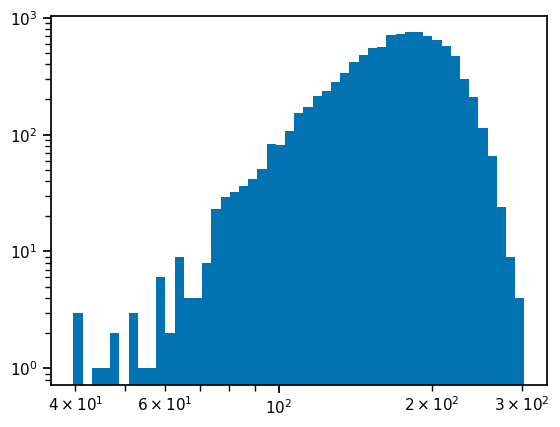

In [17]:
m_det = ms*(1+zs)
print(np.mean(ms), np.mean(zs), np.mean(m_det))
print(m_det.shape)
plt.hist(m_det, bins=np.logspace(np.log10(min(m_det)), np.log10(max(m_det)), 50))
plt.xscale('log')
plt.yscale('log')

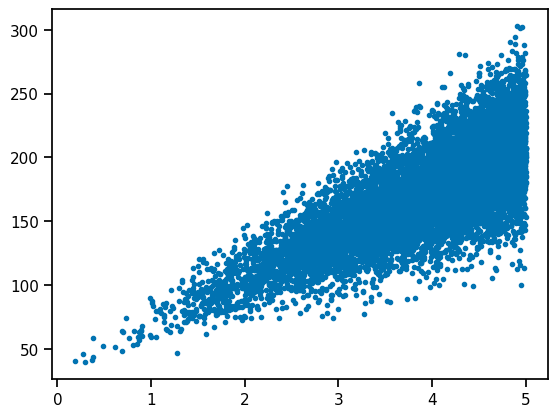

In [18]:
plt.scatter(zs, m_det, marker='.')

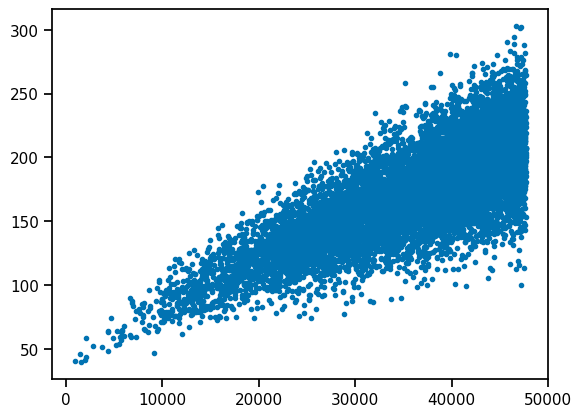

In [19]:
plt.scatter(d_Ls, m_det, marker='.')

Now those are some good looking redshift curves

In [20]:
print(min(ms), min(m_det))

16.856408677772286 39.63876498355017


100%|██████████| 4/4 [00:35<00:00,  8.76s/it]


Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

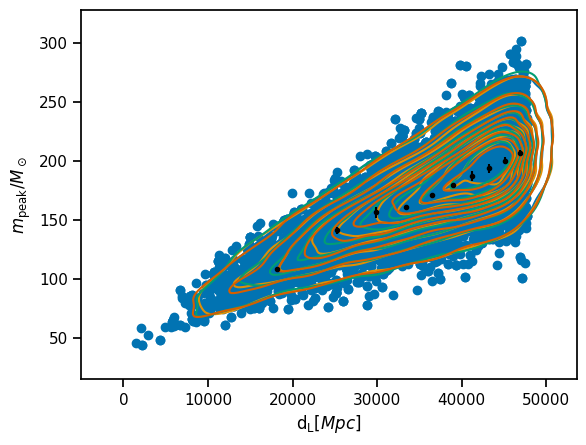

In [21]:
n_events = len(m_det)
n_dLs=10
n_mc = 4
m_min = min(m_det)
m_max = max(m_det)
dL_min = min(d_Ls)
dL_max = max(d_Ls)

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dL_cent = np.quantile(d_Ls, np.linspace(0.05, 0.95, n_dLs))

DLG, MG = np.meshgrid(dL_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dLs))

for run in tqdm(range(n_mc)):

    events = np.random.randint(n_events, size=n_events)
    
    m_det_mc = m_det[events]
    d_Ls_mc = d_Ls[events]
    
    arr = np.array([d_Ls_mc, m_det_mc])
    kde = gaussian_kde(arr)
    
    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    for i in range(n_dLs):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])
    
    kplot = sns.kdeplot(x=d_Ls_mc, y=m_det_mc)
    
plt.errorbar(dL_cent, np.mean(mpeak_samples, axis=0), 
             yerr=np.std(mpeak_samples, axis=0), fmt='.', c='k')
plt.scatter(d_Ls_mc, m_det_mc)
plt.xlabel(r'$\mathrm{d_L}[Mpc]$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')
# plt.ylim(30, 50)

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 99 seconds.
The acceptance probability does not match the target. It is 0.976, but should be close to 0.8. Try to increase the number of tuning steps.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8953, but should be close to 0.8. Try to increase the number of tuning steps.


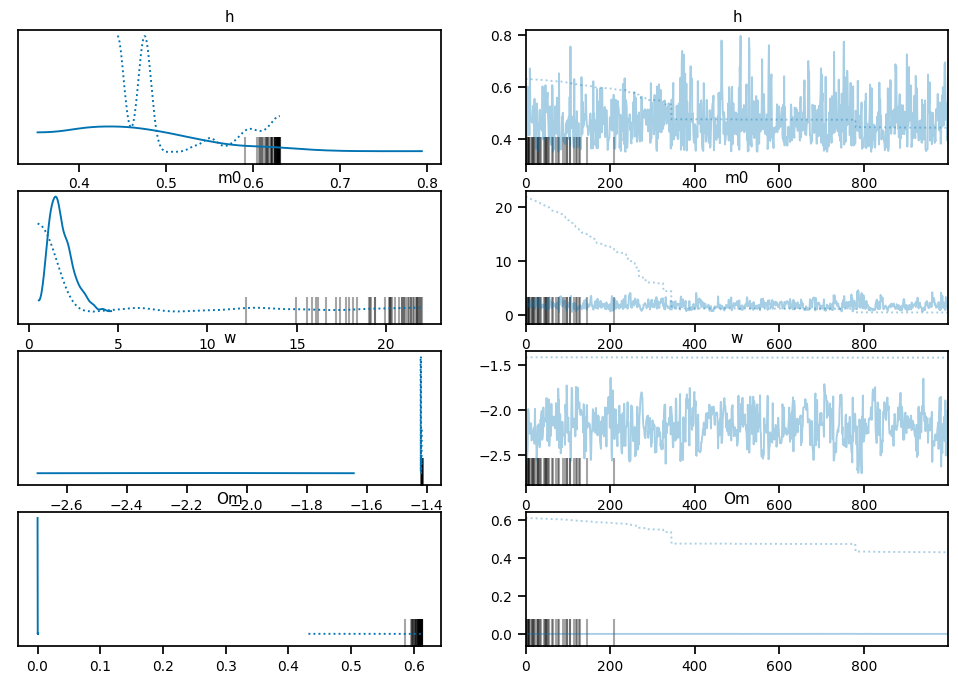

In [22]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = np.std(mpeak_samples, axis=0)


with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m+0.25*mu_m, dls=dL_cent, zmin=1, zmax=3) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

In [23]:
import matplotlib.colors as mcolors
cmap = list(mcolors.BASE_COLORS.keys())
print(len(cmap))

8


Text(0, 0.5, 'Probability Density [$\\mathrm{M_\\odot^{-1}}$]')

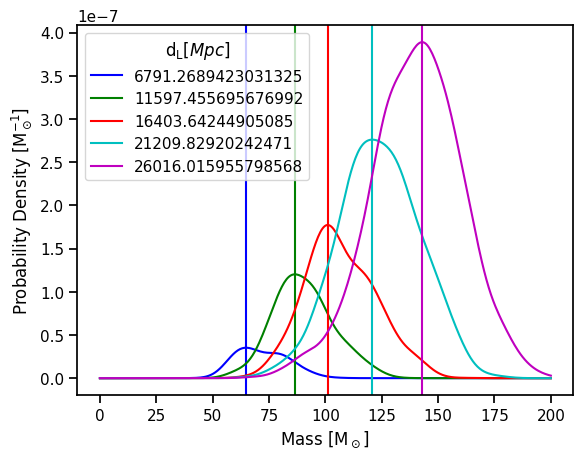

In [24]:
m_max = 200
zmn = 1
zmx = 3

mass_indices = np.linspace(0, m_max, 400)

for j,d in enumerate(np.linspace(Planck18.luminosity_distance(zmn).value,
                                 Planck18.luminosity_distance(zmx).value, 5)):
    
    pdf = [kde.pdf([d, i]) for i in mass_indices]
    plt.plot(mass_indices, pdf,c=cmap[j], label=d)
    plt.axvline(mass_indices[np.argmax(pdf)], c=cmap[j])
    
plt.legend(title=r"$\mathrm{d_L}[Mpc]$")
plt.xlabel(r"Mass [$\mathrm{M_\odot}$]")
plt.ylabel(r"Probability Density [$\mathrm{M_\odot^{-1}}$]")